<a href="https://colab.research.google.com/github/Grandediw/ml-algorthm/blob/main/LSTM_model_02_AAPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model

# Suppress TensorFlow warnings
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

# 1. Data Collection and Preprocessing

# Download the data
ticker = 'AAPl'
data = yf.download(ticker, start='2008-01-01', end='2023-10-01')  # Updated end date

# Use additional features
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Handle missing values
data.dropna(inplace=True)

# Feature Engineering: Add technical indicators
data['MA_7'] = data['Close'].rolling(window=7).mean()
data['MA_21'] = data['Close'].rolling(window=21).mean()
data['EMA_7'] = data['Close'].ewm(span=7, adjust=False).mean()
data['EMA_21'] = data['Close'].ewm(span=21, adjust=False).mean()
data['STD_7'] = data['Close'].rolling(window=7).std()
data['STD_21'] = data['Close'].rolling(window=21).std()

# Relative Strength Index (RSI)
delta = data['Close'].diff(1)
delta = delta.dropna()
up = delta.copy()
down = delta.copy()
up[up < 0] = 0
down[down > 0] = 0
time_period = 14
avg_gain = up.rolling(window=time_period).mean()
avg_loss = abs(down.rolling(window=time_period).mean())
rs = avg_gain / avg_loss
rsi = 100.0 - (100.0 / (1.0 + rs))
data['RSI'] = rsi

# Bollinger Bands
data['Upper_band'] = data['MA_21'] + (data['STD_21'] * 2)
data['Lower_band'] = data['MA_21'] - (data['STD_21'] * 2)

# Drop rows with NaN values created by rolling calculations
data.dropna(inplace=True)

# Select features and target
features = data.drop(['Close'], axis=1)
target = data['Close']

# Scale the features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
scaled_features = feature_scaler.fit_transform(features)
scaled_target = target_scaler.fit_transform(target.values.reshape(-1, 1))

# Prepare sequences
def create_sequences(features, target, time_step):
    X = []
    y = []
    for i in range(time_step, len(features)):
        X.append(features[i - time_step:i])
        y.append(target[i])
    return np.array(X), np.array(y)

# Parameters
time_step = 60
X, y = create_sequences(scaled_features, scaled_target, time_step)

# Split the data into training and testing sets (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

[*********************100%***********************]  1 of 1 completed


In [2]:
# 2. Build the LSTM Model

model = Sequential()

# First LSTM layer with Dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          12,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,251 (208.01 KB)

 Trainable params: 53,251 (208.01 KB)

 Non-trainable params: 0 (0.00 B)

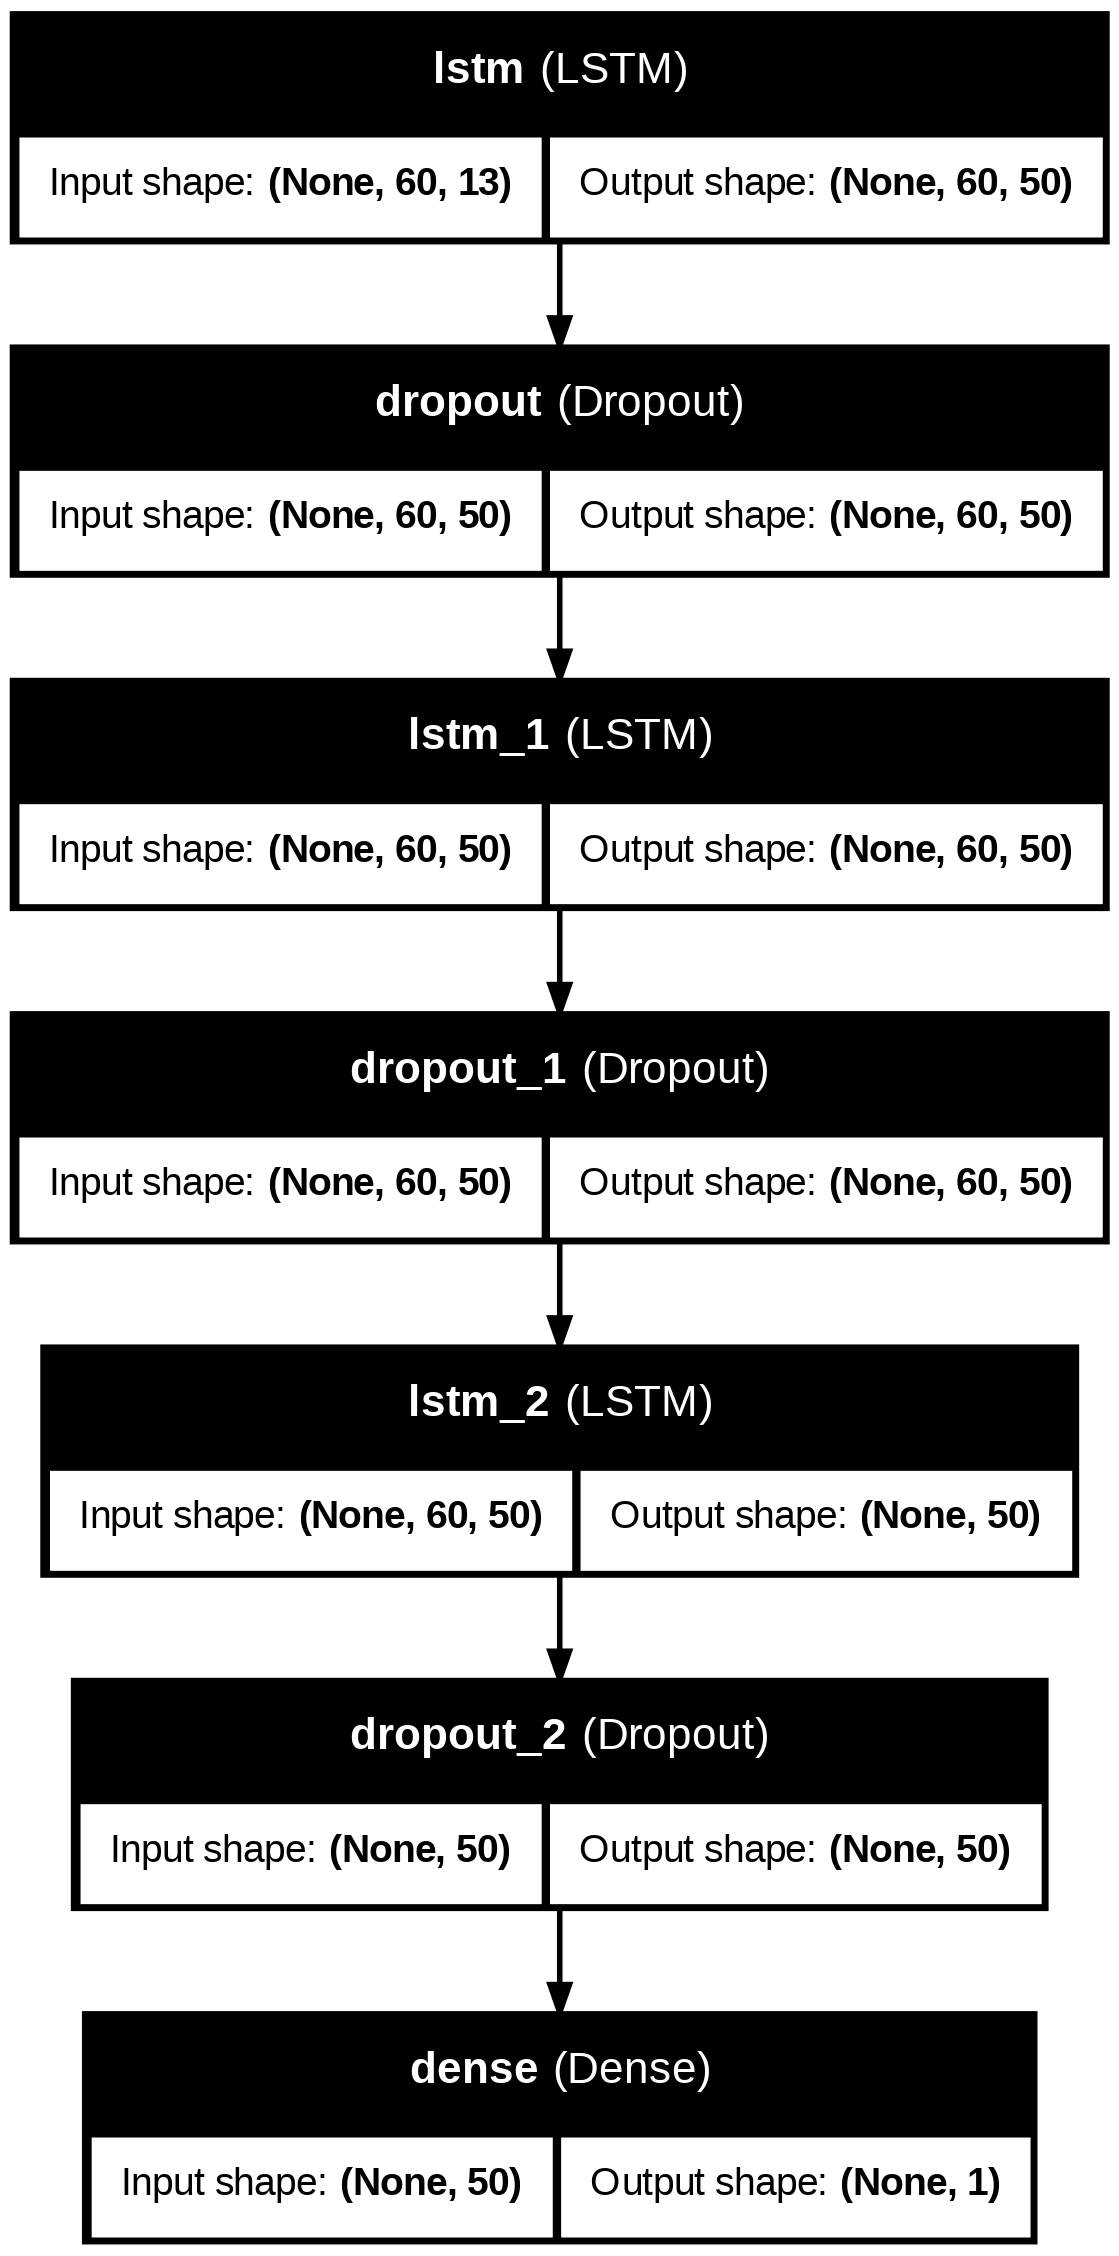

In [3]:
# Save and display the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [4]:
# 3. Train the Model

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - loss: 0.0056 - val_loss: 0.0025
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 4.2335e-04 - val_loss: 0.0022
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 4.0496e-04 - val_loss: 0.0036
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 3.5193e-04 - val_loss: 0.0024
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - loss: 3.3727e-04 - val_loss: 0.0031
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - loss: 2.7413e-04 - val_loss: 0.0107
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 3.3614e-04 - val_loss: 0.0016
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 2.9366e-04 - val_loss: 0.0019
Epoch 9/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 2.7703e-04 - val_loss: 0.0012
Epoch 10/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - loss: 2.2517e-04 - val_loss: 0.0016
Epoch 11/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - loss: 2.2819e-04 - val_loss: 0.0093
Epoch 12/20
98/

In [5]:
# 4. Evaluate the Model

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
train_predictions_inverse = target_scaler.inverse_transform(train_predictions)
y_train_inverse = target_scaler.inverse_transform(y_train)
test_predictions_inverse = target_scaler.inverse_transform(test_predictions)
y_test_inverse = target_scaler.inverse_transform(y_test)

# Compute Evaluation Metrics
def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

train_rmse = np.sqrt(mean_squared_error(y_train_inverse, train_predictions_inverse))
test_rmse = np.sqrt(mean_squared_error(y_test_inverse, test_predictions_inverse))
train_mae = mean_absolute_error(y_train_inverse, train_predictions_inverse)
test_mae = mean_absolute_error(y_test_inverse, test_predictions_inverse)
train_mape = mean_absolute_percentage_error(y_train_inverse, train_predictions_inverse)
test_mape = mean_absolute_percentage_error(y_test_inverse, test_predictions_inverse)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Train MAPE: {train_mape}%")
print(f"Test MAPE: {test_mape}%")

98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Train RMSE: 1.845975543372443
Test RMSE: 6.696517061181505
Train MAE: 1.2975389627463418
Test MAE: 5.39843816769476
Train MAPE: 5.549248889669768%
Test MAPE: 3.6511347004759895%


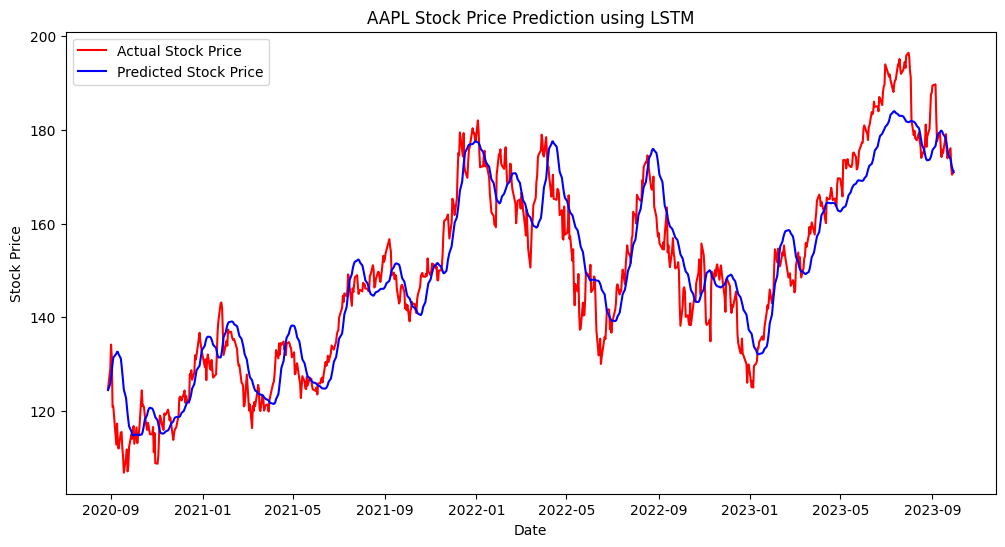

In [8]:
# 5. Visualize the Results

# Prepare dates for plotting
dates = data.index[-len(y_test_inverse):]

plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_inverse.flatten(), color='red', label='Actual Stock Price')
plt.plot(dates, test_predictions_inverse.flatten(), color='blue', label='Predicted Stock Price')
plt.title('AAPL Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

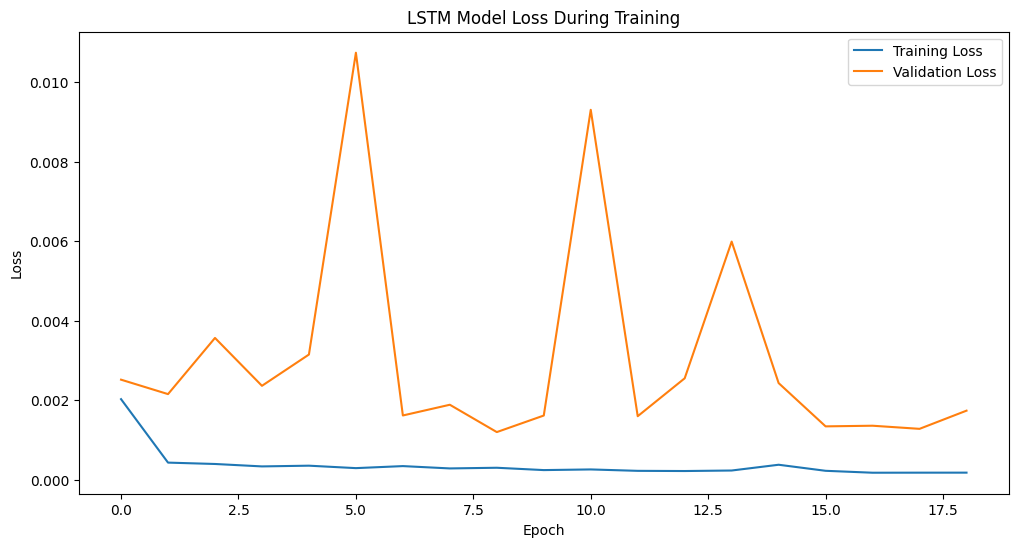

In [7]:
# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()